In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
deaths = pd.read_csv("05_cleaned_data/deaths_tx.csv")


In [3]:
## filter to only texas (only for pre-post)

texas = deaths[deaths["StateName"] == "Texas"]
comp = deaths[deaths["StateName"] != "Texas"]

### helper functions 

In [4]:
# function to select only overdose records
# double check this

def select_overdose(record):

    if record == "All other non-drug and non-alcohol causes":
        return 0

    if record == "All other alcohol-induced causes":
        return 0

    if record == "All other drug-induced causes":
        return 0

    if record == "Alcohol poisonings (overdose) (X45, X65, Y15)":
        return 0

    if record == "Drug poisonings (overdose) Unintentional (X40-X44)":
        return 1

    if record == "Drug poisonings (overdose) Suicide (X60-X64)":
        return 1

    if record == "Drug poisonings (overdose) Undetermined (Y10-Y14)":
        return 1

    else:
        return "error"
    

# copy to fix the dreaded "A value is trying to be set on a copy of a slice" error
tx_deaths = texas.copy()
comp_deaths = comp.copy()


tx_deaths["overdose"] = tx_deaths["Drug/Alcohol Induced Cause"].apply(lambda x: select_overdose(x))
comp_deaths["overdose"] = comp_deaths["Drug/Alcohol Induced Cause"].apply(lambda x: select_overdose(x))

# filter accordingly
tx_deaths = tx_deaths[tx_deaths["overdose"] != 0]
comp_deaths = comp_deaths[comp_deaths["overdose"] != 0]

In [5]:
# normalize deaths over population

tx_deaths["overdose_per_100k"] = tx_deaths["Deaths"] / tx_deaths["Population"] * 100_000
comp_deaths["overdose_per_100k"] = comp_deaths["Deaths"] / comp_deaths["Population"] * 100_000

In [6]:
tx_result = tx_deaths.groupby("Year")["overdose_per_100k"].sum().reset_index()
comp_result = comp_deaths.groupby(["Year", "StateName"])["overdose_per_100k"].sum().reset_index()

In [7]:
# collapse state column with a mean aggregation
# gives us the average overdoses of our comparison states over the years
comp_result = comp_result.groupby(["Year"])["overdose_per_100k"].mean().reset_index()

In [8]:
# create a scale for number of years before and after 2007 (target year)

def scale_years(year):
    if year == 2004:
        return -3
    if year == 2005:
        return -2
    if year == 2006:
        return -1
    if year == 2007:
        return 0
    if year == 2008:
        return 1
    if year == 2009:
        return 2
    if year == 2010:
        return 3

tx_result["year relative to policy"] = tx_result["Year"].apply(lambda x: scale_years(x))
comp_result["year relative to policy"] = comp_result["Year"].apply(lambda x: scale_years(x))

# double check no nulls in "year relative to policy"

assert (tx_result["year relative to policy"].isnull().sum() == 0)
assert (comp_result["year relative to policy"].isnull().sum() == 0)

# doing this in case the float == int comparison causes issues

## Pre-post plot - overdoses per 100k through the years

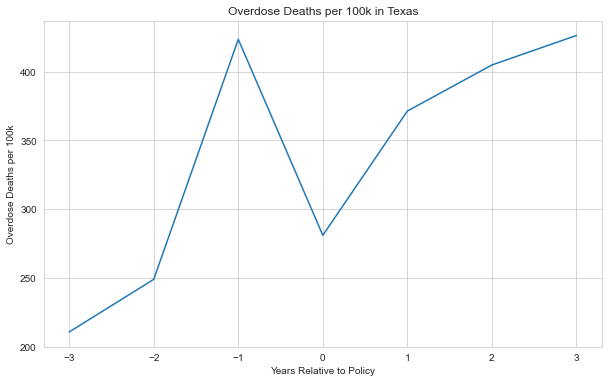

In [9]:
# plot years relative to policy vs. overdose per 100k

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

plt.figure(figsize=(10, 6))
sns.lineplot(x="year relative to policy", y="overdose_per_100k", data=tx_result)
plt.title("Overdose Deaths per 100k in Texas")
plt.xlabel("Years Relative to Policy")
plt.ylabel("Overdose Deaths per 100k")
plt.show()


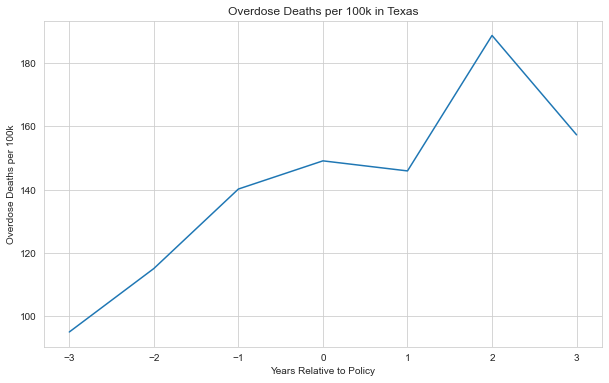

In [10]:
# plot years relative to policy vs. overdose per 100k

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

plt.figure(figsize=(10, 6))
sns.lineplot(x="year relative to policy", y="overdose_per_100k", data=comp_result)
plt.title("Overdose Deaths per 100k in Texas")
plt.xlabel("Years Relative to Policy")
plt.ylabel("Overdose Deaths per 100k")
plt.show()
